In [95]:
import numpy as np
from matplotlib import pyplot as plt
import numpy.linalg as nl
import os
import h5py
import fipy as fp
from fipy import Gmsh2D
import itertools
import cmath
import pandas as pd
import sys; sys.path.append('../')
import analysis.image_analysis as ia
from PIL import Image
from scipy.optimize import minimize

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20
plt.rcParams["text.usetex"]=True

## Non-dimensionalized model for RNA-Protein system with phase separation and transcription without any approximations

C = Protein. M = RNA.

Non-dimensionalized equations in real space (dropping the tildes):

$$
\partial_{t} c = M \nabla^2 \Big( (c-1)^3 + \beta (c-1) + \chi m - \kappa \nabla^2 c \Big) \\
\partial_{t} m = \nabla^2 \Big( m + \chi w c \Big) + K c - m \\
$$

where $w = \frac{1}{\lambda}$. For concentrations close to the spinodal region's center (i.e. $c = 1$), we can drop the cubic term $(c-1)^3$ and get a linear set of equations for the concentration fields. 

$$
\partial_{t} c = M \nabla^2 \Big( \beta (c-1) + \chi m - \kappa \nabla^2 c \Big) \\
\partial_{t} m = \nabla^2 \Big( m + \chi w c \Big) + K c - m \\
$$

The Fourier Transform of these linear equations looks like:

$$
\partial_t \begin{bmatrix} c_q \\ m_q \end{bmatrix} = 
\begin{bmatrix} -M \beta q^2 - M \kappa q^4 & -M \chi q^2 \\ -\chi w q^2 + K & -1-q^2 \end{bmatrix} 
\begin{bmatrix} c_q \\ m_q \end{bmatrix}
$$

The trace and determinant of this Jacobian are given by the following expressions:
$$
Tr(J) = - M \kappa q^4 - (M \beta + 1) q^2 - 1 \\
Det(J) = M \kappa q^6 + (M \kappa + M \beta - M \chi^2 w) q^4 + q^2 (M \chi K +  M \beta)
$$

In [3]:
class LSA:
    """
    Class that defines the dynamical model for the C-M system
    """
    
    def __init__(self, params):
        """
        Parameters of the model are M, beta, chi, K
        """
        self.M = params['M'] # Ratio of diffusivities of M to C
        self.beta = params['beta'] # Nature of C-C interactions. Attraction if negative
        self.chi = params['chi'] # Nature of C-M interactions. Attractive if negative
        self.K = params['K'] # Ratio of production to degradation rate constants of M
        self.kappa = params['kappa'] # Ratio of surface tension to reaction-diffusion length scale
        self.w = params['w'] # Inverse of the M-M interaction strength
        
    def _get_eigenvalues(self, q):
        """
        Fuction that returns a 2x1 vector containing the eigenvalues of the Jacobian matrix
        """
        J = np.array([[-self.M*self.beta*q**2 - self.M*self.kappa*q**4, -self.M*self.chi*q**2],
                      [-self.chi*self.w*q**2 + self.K, -1.0-q**2]], 
                     dtype=float)
        eigenvals, eigenvecs = nl.eig(J)
        return eigenvals
    
    def update_beta(self, beta):
        """
        Function that updates beta value
        """
        self.beta = beta
        
    def update_K(self, K):
        """
        Function that updates K value
        """
        self.K = K
    
    def _get_trace(self, q):
        """
        Function that returns the trace of the Jacobian matrix of the linearized model
        """
        return -self.M*self.kappa*q**4 -(self.M*self.beta + 1.0)*q**2 - 1.0
    
    def _get_det(self, q):
        """
        Function that returns the determinant of the Jacobian matrix of the linearized model
        """
        return (self.M*self.kappa*q**6 + (self.M*self.kappa + self.M*self.beta - self.M*self.chi**2*self.w)*q**4 
                + q**2*(self.M*self.chi*self.K + self.M*self.beta))
    
    def _get_phase_plot_data(self, q_range):
        """
        Function that takes in a range of values of the wave number q_range, and computes the determinant and trace
        """
        trace_range = self._get_trace(q_range)
        det_range = self._get_det(q_range)
        return trace_range, det_range
    
    def plot_phase_plot(self, ax, q_range):
        """
        Function to generate phase plots that help us visualize the different dynamical behaviors when perturbed about a steady state
        """
        trace, det = self._get_phase_plot_data(q_range)
        
        # plot the regions of different dynamical behaviors
        x_max = np.max(np.abs(trace))
        y_max = np.max(np.abs(det))
        x_range = np.linspace(-1.2*x_max, 1.2*x_max, 50)
        y_oscillatory_region = x_range**2/4.0
        ax.plot(x_range, y_oscillatory_region, '-k', linewidth=1)
        
        # Plot the phase plot for this model parameters
        ax.plot(trace, det, '-r', linewidth=2)
        ax.set_xlim([-1.2*x_max, 1.2*x_max])
        ax.set_ylim([-1.2*y_max, 1.2*y_max])
        
        ax.set_xlabel('tr(J)')
        ax.set_ylabel('det(J)')
        ax.axhline(y=0.0, color='k', linestyle='-')
        ax.axvline(x=0.0, color='k', linestyle='-')
    
    def calculate_eigenvalue_spectrum(self, q_list):
        """
        Function that calculates the eigenvalues of the jacobian matrix for different values of q in q_list
        """

        spectrum = np.zeros(len(q_list))

        for i in range(len(q_list)):

            trace_J = self._get_trace(q_list[i])
            det_J = self._get_det(q_list[i])

            eigenvalues = [0.5*(trace_J + cmath.sqrt(trace_J**2-4*det_J)), 0.5*(trace_J - cmath.sqrt(trace_J**2-4*det_J))]
            spectrum[i] = np.max(np.real(eigenvalues))

        return spectrum

    def get_qualitative_behavior(self, q_list):
        """
        Function that returns the qualitative dynamical behavior of the model as predicted by the linear stability analysis
        Returns: 
        0 for stable system
        1 for unstable system with coarsening
        2 for unstable system with patterns/arrested coarsening
        3 for unstable system with oscillations
        """
        
        behavior = 0
        # Start with the default assumption that the system is stable
        # If we find the system is unstable for any particular wavenumber q^2, then we will change the behavior accordingly
        
        flag_for_first_q_with_positive_eigenvalue = 1
        first_q_with_positive_eigenvalue = 0.0
        
        for q in q_list:
            
            trace_J = self._get_trace(q)
            det_J = self._get_det(q)
            
            if trace_J > 0.0 and det_J > 0.25*trace_J**2: 
                # We have limit cycle oscillations
                behavior = 3
                break
            
            elif (trace_J > 0.0 and det_J < 0.25*trace_J**2) or (det_J < 0.0 and trace_J < 0.0):
                # We have coarsening
                behavior = 1
            
            eigenvalues = [0.5*(trace_J + cmath.sqrt(trace_J**2-4*det_J)), 0.5*(trace_J - cmath.sqrt(trace_J**2-4*det_J))]
            max_real_part = np.max(np.real(eigenvalues))
            if max_real_part > 0.0 and flag_for_first_q_with_positive_eigenvalue:
                flag_for_first_q_with_positive_eigenvalue = 0
                first_q_with_positive_eigenvalue = q
        
        if behavior == 1 and first_q_with_positive_eigenvalue > q_list[1]:
            # We have arrested coarsening
            behavior = 2
            
        return behavior, first_q_with_positive_eigenvalue

### Start with the base model where $M\kappa = 0$ and $w = 0$

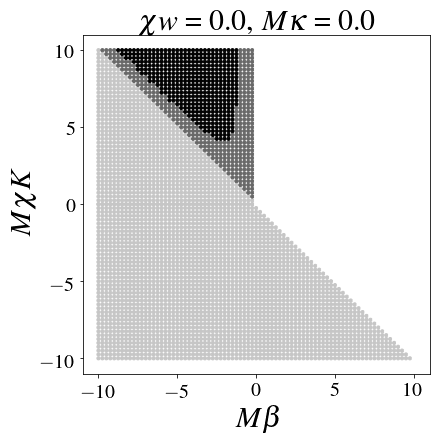

In [227]:
params = {'M': 1.0, 'beta': -1.0, 'chi': 1.0, 'K': 1.0, 'kappa': 0.1, 'w': 0.1}
q_range = np.linspace(0, 10, 401)
N_parameter_points = 81

beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
K_range = np.linspace(0.0, 10.0, N_parameter_points//2+1)
sweep_parameter_values = np.array([beta_range, K_range])
X, Y = np.meshgrid(beta_range, K_range)

w_list = [0.0]
kappa_list = [0.0]

fig, axs = plt.subplots(len(kappa_list), len(w_list), figsize=(6*len(w_list),6*len(kappa_list)), constrained_layout = True)

for kap in range(len(kappa_list)):
    for k in range(len(w_list)):

        params['w'] = w_list[k]
        params['kappa'] = kappa_list[kap]

        params['chi'] = 1.0
        nondim_model = LSA(params)
        qualitative_behavior_1 = np.zeros(np.shape(X))

        for i in range(N_parameter_points//2+1):
            for j in range(N_parameter_points):
                nondim_model.update_beta(X[i,j])
                nondim_model.update_K(Y[i,j])
                qualitative_behavior_1[i,j], first_q = nondim_model.get_qualitative_behavior(q_range)

        params['chi'] = -1.0
        nondim_model = LSA(params)
        qualitative_behavior_2 = np.zeros(np.shape(X))

        for i in range(N_parameter_points//2+1):
            for j in range(N_parameter_points):
                nondim_model.update_beta(X[i,j])
                nondim_model.update_K(Y[i,j])
                qualitative_behavior_2[i,j], first_q = nondim_model.get_qualitative_behavior(q_range)

        axs.scatter(np.append(X.flatten(), X.flatten()), 
                    np.append(Y.flatten(), -1.0*Y.flatten()), 
                    c=np.append(qualitative_behavior_1.flatten(), qualitative_behavior_2.flatten()), 
                    s=10, cmap='Greys')
        
        axs.set_xlabel(r'$M\beta$', fontsize=30)
        axs.set_ylabel(r'$M\chi K$', fontsize=30)
        axs.tick_params(axis='both', which='major', labelsize=20)
        axs.set_title(r'$\chi w$ = ' + str(w_list[k]) + r', $M\kappa$ = ' + str(kappa_list[kap]), fontsize=30)

plt.savefig('Figures_for_paper/Figure_1/20230804_Base_phase_diagram.svg', dpi=600, format='svg')
plt.savefig('Figures_for_paper/Figure_1/20230804_Base_phase_diagram.png', dpi=600, format='png')

## Approximation with $w=0$ that gives rise to purely diffusion equation for the RNA species

**Question:** What happens when the RNA does not just purely diffuse, but moves around as a consequence of reciprocal interactions? In the below, we investigate what happens as we increase $w$. When $w=0$, the RNA undergoes pure diffusion and there are no reciprocal interactions. When $w > 0$ we have reciprocal interactions with the RNA-protein repulsion becoming stronger compared to the RNA-RNA repulsion and therefore having more impact on the RNA dynamics. 

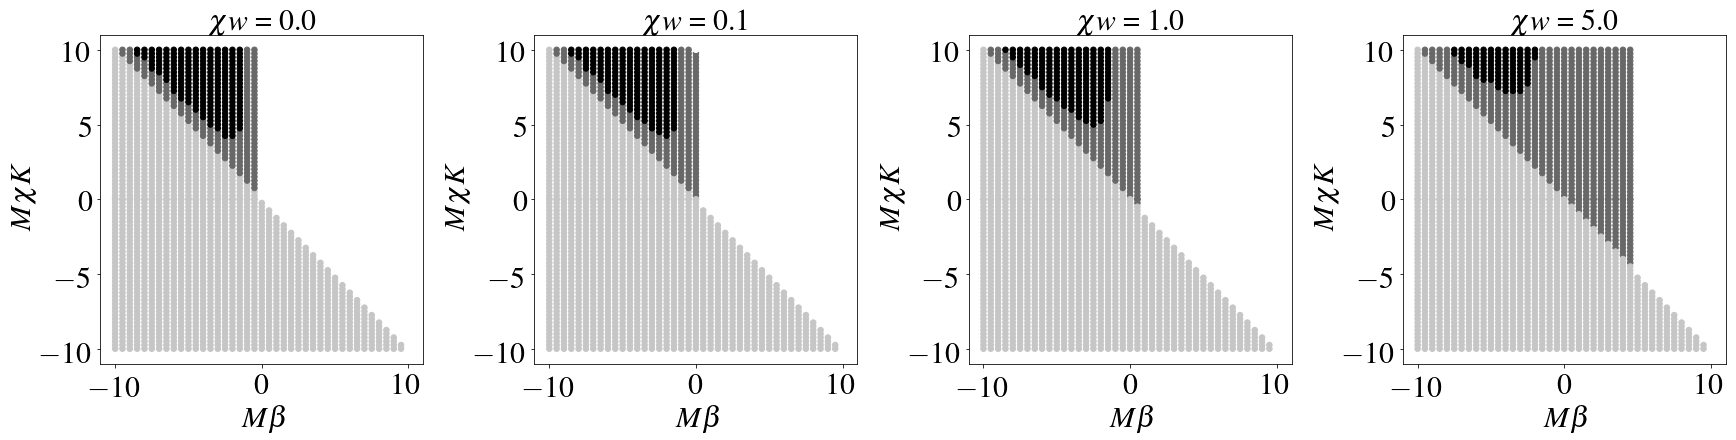

In [228]:
fig, axs = plt.subplots(1, 4, figsize=(24,6), constrained_layout = True)

params = {'M': 1.0, 'beta': 1.0, 'chi': 1.0, 'K': 1.0, 'kappa': 0.0, 'w': 0.0}
q_range = np.linspace(0, 10, 401)
N_parameter_points = 41

beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
K_range = np.linspace(0.0, 10.0, N_parameter_points)
sweep_parameter_values = np.array([beta_range, K_range])
X, Y = np.meshgrid(beta_range, K_range)

w_list = [0.0, 0.1, 1.0, 5.0]

for k in range(len(w_list)):
    
    params['w'] = w_list[k]
    
    params['chi'] = 1.0
    nondim_model = LSA(params)
    qualitative_behavior_1 = np.zeros(np.shape(X))

    for i in range(N_parameter_points):
        for j in range(N_parameter_points):
            nondim_model.update_beta(X[i,j])
            nondim_model.update_K(Y[i,j])
            qualitative_behavior_1[i,j], first_q = nondim_model.get_qualitative_behavior(q_range)

    params['chi'] = -1.0
    nondim_model = LSA(params)
    qualitative_behavior_2 = np.zeros(np.shape(X))

    for i in range(N_parameter_points):
        for j in range(N_parameter_points):
            nondim_model.update_beta(X[i,j])
            nondim_model.update_K(Y[i,j])
            qualitative_behavior_2[i,j], first_q = nondim_model.get_qualitative_behavior(q_range)
    
    axs[k].scatter(np.append(X.flatten(), X.flatten()), 
                np.append(Y.flatten(), -1.0*Y.flatten()), 
                c=np.append(qualitative_behavior_1.flatten(), qualitative_behavior_2.flatten()), 
                s=30, cmap='Greys')
    axs[k].set_xlabel(r'$M\beta$', fontsize=30)
    axs[k].set_ylabel(r'$M\chi K$', fontsize=30)
    axs[k].tick_params(axis='both', which='major', labelsize=30)
    axs[k].set_title(r'$\chi w$ = ' + str(w_list[k]), fontsize=30)
    
plt.savefig('Figures_for_paper/Figure_1/20230804_Comparing_Model_AB_with_RD_dynamics.svg', dpi=600, format='svg')
plt.savefig('Figures_for_paper/Figure_1/20230804_Comparing_Model_AB_with_RD_dynamics.png', dpi=600, format='png')

**Results:** 

1. When we have reciprocal interactions for the RNA species rather than just pure diffusion equation for the RNA species, we can get an additional finite size pattern in the regime where $M\beta>0$ and $M\chi K > 0$. This happens due to the following reason:

    Whenever there is a perturbation that leads to the accumulation of protein in space, that region produces RNA, which fluxes out of this dense region of protein due to RNA-protein repulsion and RNA diffusion. This leads to a phase rich in RNA, and another phase rich in protein. These two phases are stable because:
    * The RNA concentration in the RNA-rich phase is maintained due to a balance between the influx of RNA from the protein-dense phase and the degradation of RNA. The RNA concentration in the protein-rich phase is maintained due to a balance between RNA production due to the protein, RNA outflux and RNA degradation. 
    *  The protein concentration in the protein dense phase is maintained due to a balance between the outflux of protein due to diffusion and influx of protein that is pushed away by the RNA-rich phase. 

    Mathematically, we find that when $M\beta > 0$ and $M \chi K > 0$, in the limit where $M\kappa << 1$, we have:
    $$
    Tr(J) = - (M \beta + 1) q^2 - 1 \\
    Det(J) = (M \beta - M \chi^2 w) q^4 + q^2 (M \chi K +  M \beta)
    $$
    
    $Tr(J)$ is < 0 for all $q^2 > 0$ when $M\beta > -1$. The boundary of stability is given by solving $det(J) > 0$ for all $q^2 > 0$. This happens when $M \beta - M \chi^2 w > 0$ and $M \chi K > -M \beta$. 
    
2. Having reciprocal interactions with increasing relevance of RNA-protein interactions in driving RNA transport also reduces the range of parameters for which oscillations happen, as can be seen from the above plot comparing the case with w = 0.1 vs. w = 1.0 (Can't think of a way to tie this to biology)

    For oscillations, we require $trace(J) > 0$ and $det(J) > trace(J)^2/4$ for some values of $q^2 > 0$. For the trace condition, we require that $M\beta < -1$. For the det condition, we have 

## Effect of surface tension

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (49) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (48) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (77) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmri8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389:

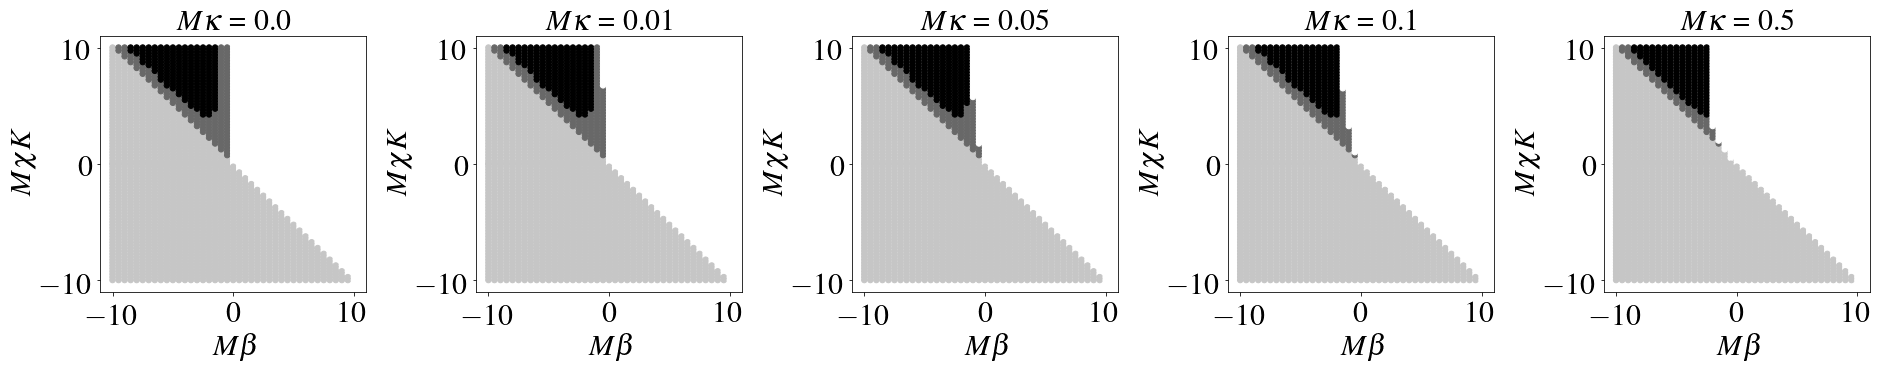

In [29]:
%matplotlib inline
fig, axs = plt.subplots(1, 5, figsize=(26,5), constrained_layout = True)

params = {'M': 1.0, 'beta': 1.0, 'chi': 1.0, 'K': 1.0, 'kappa': 0.0, 'w': 0.0}
q_range = np.linspace(0, 10, 401)
N_parameter_points = 41

beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
K_range = np.linspace(0.0, 10.0, N_parameter_points)
sweep_parameter_values = np.array([beta_range, K_range])
X, Y = np.meshgrid(beta_range, K_range)

kappa_list = [0.0, 0.01, 0.05, 0.1, 0.5]

for k in range(len(kappa_list)):
    
    params['kappa'] = kappa_list[k]
    
    params['chi'] = 1.0
    nondim_model = LSA(params)
    qualitative_behavior_1 = np.zeros(np.shape(X))

    for i in range(N_parameter_points):
        for j in range(N_parameter_points):
            nondim_model.update_beta(X[i,j])
            nondim_model.update_K(Y[i,j])
            qualitative_behavior_1[i,j], first_q = nondim_model.get_qualitative_behavior(q_range)

    params['chi'] = -1.0
    nondim_model = LSA(params)
    qualitative_behavior_2 = np.zeros(np.shape(X))

    for i in range(N_parameter_points):
        for j in range(N_parameter_points):
            nondim_model.update_beta(X[i,j])
            nondim_model.update_K(Y[i,j])
            qualitative_behavior_2[i,j], first_q = nondim_model.get_qualitative_behavior(q_range)
    
    axs[k].scatter(np.append(X.flatten(), X.flatten()), 
                np.append(Y.flatten(), -1.0*Y.flatten()), 
                c=np.append(qualitative_behavior_1.flatten(), qualitative_behavior_2.flatten()), 
                s=30, cmap='Greys')
    axs[k].set_xlabel(r'$M\beta$', fontsize=30)
    axs[k].set_ylabel(r'$M\chi K$', fontsize=30)
    axs[k].tick_params(axis='both', which='major', labelsize=30)
    axs[k].set_title(r'$M\kappa$ = ' + str(kappa_list[k]), fontsize=30)

plt.savefig('Figures_for_paper/Figure_1/20230804_Effect_of_surface_tension.svg', dpi=600, format='svg')
plt.savefig('Figures_for_paper/Figure_1/20230804_Effect_of_surface_tension.png', dpi=600, format='png')

**Result:** Surface tension suppresses pattern formation at higher values of $M\chi K$. This can be intuitively explained in the following way: The lowest wave number that is unstable is given by $q^* = \sqrt{\chi K / \beta - 1}$. Therefore, as $\chi K$ increases, the lowest wave number that is unstable also increases, which means that the wavelength of the pattern becomes smaller. When the wavelength of the pattern becomes too small, the surface tension effects start to kick in. From a field theory perspective, surface tension energetically penalizes sharp gradients and therefore destabilizes these small wavelength patterns. From a sharp interface model perspective, smaller patterns have a larger interface area in relation to the bulk and are therefore become destabilized due to higher interfacial energy. 

Mathematically, when when the protein-protein phase separation is weak i.e. $M\beta << 1$, we have the trace and determinant to be:

$$
Tr(J) = - M \kappa q^4 - (M\beta + 1) q^2 - 1 \\
Det(J) = M \kappa q^6 + (M \kappa + M \beta) q^4 + q^2 (M \chi K +  M \beta)
$$

The Tr(J) is always < 0 and the system can be stable only if det(J) > 0. Therefore, the criterion for surface tension stabilizing the system and destroying the pattern formation instability is when det(J) > 0 for all values of $q$. No clearly the det(J) is a quadratic function in $q^2$, after factoring out the common $q^2$ in all terms. This quadratic equation is always positive iff $M \kappa > $ and discriminant < 0. 

The mathematical condition is $(M \kappa + M \beta)^2 - 4(M \chi K +  M \beta)M\kappa < 0 \Rightarrow M\chi K > (M\kappa-M\beta)^2/4M\kappa $ 

## Combined effect of surface tension and recprocity of interactions

In [ ]:
params = {'M': 1.0, 'beta': -1.0, 'chi': 1.0, 'K': 1.0, 'kappa': 0.05, 'w': 0.0}
q_range = np.linspace(0, 10, 401)
N_parameter_points = 41

beta_range = np.linspace(-10.0, 10.0, N_parameter_points)
K_range = np.linspace(0.0, 10.0, N_parameter_points)
sweep_parameter_values = np.array([beta_range, K_range])
X, Y = np.meshgrid(beta_range, K_range)

w_list = [0.0, 0.1, 1.0, 5.0]
kappa_list = [0.05, 0.1, 0.2]

fig, axs = plt.subplots(len(kappa_list), len(w_list), figsize=(6*len(w_list),6*len(kappa_list)), constrained_layout = True)

for kap in range(len(kappa_list)):
    for k in range(len(w_list)):

        params['w'] = w_list[k]
        params['kappa'] = kappa_list[kap]

        params['chi'] = 1.0
        nondim_model = LSA(params)
        qualitative_behavior_1 = np.zeros(np.shape(X))

        for i in range(N_parameter_points):
            for j in range(N_parameter_points):
                nondim_model.update_beta(X[i,j])
                nondim_model.update_K(Y[i,j])
                qualitative_behavior_1[i,j], first_q = nondim_model.get_qualitative_behavior(q_range)

        params['chi'] = -1.0
        nondim_model = LSA(params)
        qualitative_behavior_2 = np.zeros(np.shape(X))

        for i in range(N_parameter_points):
            for j in range(N_parameter_points):
                nondim_model.update_beta(X[i,j])
                nondim_model.update_K(Y[i,j])
                qualitative_behavior_2[i,j], first_q = nondim_model.get_qualitative_behavior(q_range)

        axs[kap,k].scatter(np.append(X.flatten(), X.flatten()), 
                    np.append(Y.flatten(), -1.0*Y.flatten()), 
                    c=np.append(qualitative_behavior_1.flatten(), qualitative_behavior_2.flatten()), 
                    s=30, cmap='Greys')
        axs[kap,k].set_xlabel(r'$M\beta$', fontsize=30)
        axs[kap,k].set_ylabel(r'$M\chi K$', fontsize=30)
        axs[kap,k].tick_params(axis='both', which='major', labelsize=30)
        axs[kap,k].set_title(r'$\chi w$ = ' + str(w_list[k]) + r', $M\kappa$ = ' + str(kappa_list[kap]), fontsize=30)

plt.savefig('Figures_for_paper/Figure_1/20230804_Combined_surface_tension_reciprocity.svg', dpi=600, format='svg')
plt.savefig('Figures_for_paper/Figure_1/20230804_Combined_surface_tension_reciprocity.png', dpi=600, format='png')

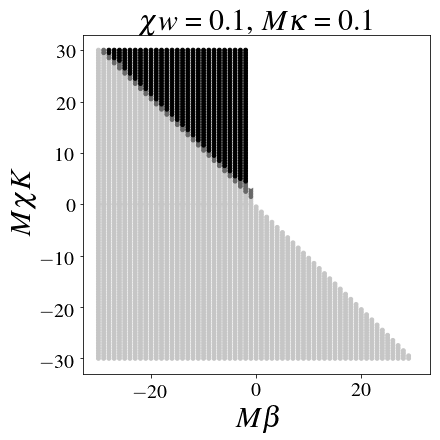

In [111]:
params = {'M': 1.0, 'beta': -1.0, 'chi': 1.0, 'K': 1.0, 'kappa': 0.1, 'w': 0.1}
q_range = np.linspace(0, 10, 401)
N_parameter_points = 61

beta_range = np.linspace(-5.0, 5.0, N_parameter_points)
K_range = np.linspace(0.0, 30.0, N_parameter_points)
sweep_parameter_values = np.array([beta_range, K_range])
X, Y = np.meshgrid(beta_range, K_range)

w_list = [0.1]
kappa_list = [0.1]

fig, axs = plt.subplots(len(kappa_list), len(w_list), figsize=(6*len(w_list),6*len(kappa_list)), constrained_layout = True)

for kap in range(len(kappa_list)):
    for k in range(len(w_list)):

        params['w'] = w_list[k]
        params['kappa'] = kappa_list[kap]

        params['chi'] = 1.0
        nondim_model = LSA(params)
        qualitative_behavior_1 = np.zeros(np.shape(X))

        for i in range(N_parameter_points):
            for j in range(N_parameter_points):
                nondim_model.update_beta(X[i,j])
                nondim_model.update_K(Y[i,j])
                qualitative_behavior_1[i,j], first_q = nondim_model.get_qualitative_behavior(q_range)

        params['chi'] = -1.0
        nondim_model = LSA(params)
        qualitative_behavior_2 = np.zeros(np.shape(X))

        for i in range(N_parameter_points):
            for j in range(N_parameter_points):
                nondim_model.update_beta(X[i,j])
                nondim_model.update_K(Y[i,j])
                qualitative_behavior_2[i,j], first_q = nondim_model.get_qualitative_behavior(q_range)

        axs.scatter(np.append(X.flatten(), X.flatten()), 
                    np.append(Y.flatten(), -1.0*Y.flatten()), 
                    c=np.append(qualitative_behavior_1.flatten(), qualitative_behavior_2.flatten()), 
                    s=15, cmap='Greys')
        
        axs.set_xlabel(r'$M\beta$', fontsize=30)
        axs.set_ylabel(r'$M\chi K$', fontsize=30)
        axs.tick_params(axis='both', which='major', labelsize=20)
        axs.set_title(r'$\chi w$ = ' + str(w_list[k]) + r', $M\kappa$ = ' + str(kappa_list[kap]), fontsize=30)

plt.savefig('Figures_for_paper/Figure_1/20230804_Base_phase_diagram.svg', dpi=600, format='svg')
plt.savefig('Figures_for_paper/Figure_1/20230804_Base_phase_diagram.png', dpi=600, format='png')

## Mapping out the phenomenology of the model

### Impact of transcription rate on wave number of pattern

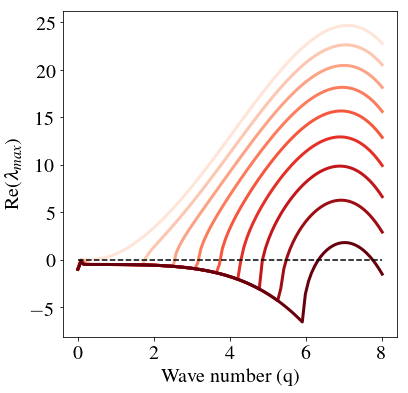

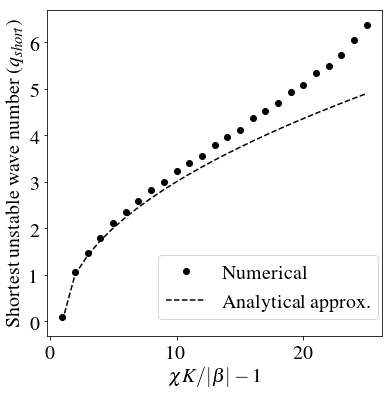

In [117]:
fig, axs = plt.subplots(1, 1, figsize=(6,6))

K_list = np.linspace(1.0, 25.0, 25)
shortest_unstable_wave_numbers = np.zeros(len(K_list))

cmap = plt.get_cmap('Reds')
cvalues = np.linspace(0.1, 1.0, len(K_list))

for j in range(len(K_list)):
    
    K = K_list[j]
    
    params = {'M': 10.0, 'beta': -0.1, 'chi': 0.1, 'K': K, 'kappa': 0.001, 'w': 0.1}

    q_range = np.linspace(0, 8, 100)

    analysis_obj = LSA(params)
    eigenvals = np.array([analysis_obj._get_eigenvalues(q_range[i]) for i in range(np.shape(q_range)[0])])
    
    if j % 3 == 0:
        axs.plot(q_range, np.real(eigenvals[:, 0]), linewidth=3, c=cmap(cvalues[j]))
    
    crossover_index = 0
    for i in range(1, len(eigenvals[:, 0])-1):
        if np.real(eigenvals[i-1, 0]) < 0.0 and np.real(eigenvals[i+1, 0]) > 0.0:
            crossover_index = i
    # print('The short wavenumber cutoff is:' + str(q_range[crossover_index]))
    # print('The longest wavelength that is unstable is:' + str(2*np.pi/q_range[crossover_index]))
    shortest_unstable_wave_numbers[j] = q_range[crossover_index]

axs.plot(q_range, np.zeros(len(q_range)), '--k')
axs.set_xlabel('Wave number (q)')
axs.set_ylabel(r'Re($\lambda_{max}$)')
plt.savefig('Figures_for_paper/Figure_1/20230807_eigenvalue_spectrum.png', 
            dpi=600, format='png', bbox_inches='tight', pad_inches=0.0)
plt.savefig('Figures_for_paper/Figure_1/20230807_eigenvalue_spectrum.svg', 
            dpi=600, format='svg', bbox_inches='tight', pad_inches=0.0)

# Plot the short wavenumber cutoff
gamma = 0.1
beta = 0.1
fig, axs = plt.subplots(1, 1, figsize=(6,6))
axs.plot(np.array(K_list)*gamma/beta, shortest_unstable_wave_numbers, 'ko', label='Numerical')
axs.plot(np.array(K_list)*gamma/beta, np.sqrt(np.array(K_list)*gamma/beta - 1.0), '--k', label='Analytical approx.')
axs.set_xlabel(r'$\chi K / |\beta| - 1$')
axs.set_ylabel(r'Shortest unstable wave number ($q_{short}$)')
axs.legend(loc='center left', bbox_to_anchor=(0.3, 0.15), fontsize=20)
plt.savefig('Figures_for_paper/Figure_1/20230807_short_wavenumber_cutoff.png', 
            dpi=600, format='png', bbox_inches='tight', pad_inches=0.0)
plt.savefig('Figures_for_paper/Figure_1/20230807_short_wavenumber_cutoff.svg', 
            dpi=600, format='svg', bbox_inches='tight', pad_inches=0.0)

### Compare dominant wave number with the wavenumber predicted by the Lyapunov functional

The Lypunov functional when expanded upto quadratic order in Fourier modes of the concentration perturbations about steady state yields:

$\mathcal{L} \approx - \sum_{\vec{q}} \biggl[\frac{f''_{bulk}(\overline{c})}{2} + \frac{\kappa}{2} q^2 + \frac{\chi}{2} \int \!\!d^3 \vec{x} \, G(\vec{x}) e^{-i\vec{q}\cdot\vec{x}} \biggr] \, |c_q|^2$

Where the Green's function is:

$G(\vec{x}) = \int\! \frac{d^3\vec{q}}{(2\pi)^3} \,
    \frac{K - \chi w q^2}{1 + q^2} \, e^{i \vec{q}\cdot \vec{x}}$
    
Therefore, combining the above expressions, we have the expression:

$\mathcal{L} \approx - \sum_{\vec{q}} \biggl[\frac{f''_{bulk}(\overline{c})}{2} + \frac{\kappa}{2} q^2 + \frac{\chi}{2} \frac{K - \chi w q^2}{1 + q^2} \biggr] \, |c_q|^2$

For our model, we have $ f''_{bulk}(\overline{c}) = 3(\overline{c}-1)^2 + \beta \approx \beta$ close to the center of the spinodal region (i.e. $\overline{c} \approx 1$). Thus, we can write out the expansion of the Lyapunov functional as:

$\mathcal{L} \approx \sum_{\vec{q}} S(q) \, |c_q|^2$

Where,

$S(q) = \biggl[\frac{\beta}{2} + \frac{\kappa}{2} q^2 + \frac{\chi}{2} \frac{K - \chi w q^2}{1 + q^2} \biggr] $

The modes $q$ having a negative coefficient $S(q) < 0$ will grow with time while the modes that have a positive coefficient $S(q) > 0$ will shrink with time. The dominant mode corresponds to the mode $q$ having the most negative value of $S(q)$, i.e. the minima of the function $S(q)$

In the limit where $\chi w << 1$, we can analytically derive that 

$q^2_{dominant} = \sqrt{\frac{\chi K}{\kappa}} - 1$


In [96]:
def S_of_q(q, params):
    """Function that returns the value of S(q) for different values of q
    
    Input:
    params(dict): A dictionary containing the model parameters
    q(float): The wave number
    
    Returns:
    S(float): The growth coefficient S(q)
    """
    
    beta = params['beta']
    kappa = params['kappa']
    chi = params['chi']
    K = params['K']
    w = params['w']
    
    S = 0.5*beta + 0.5*kappa*q**2 + 0.5*chi*(K - chi*w*q**2)/(1+q**2)
    return S

Text(0,0.5,'$S(q)$')

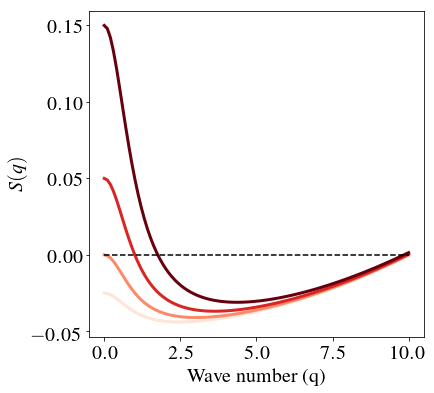

In [97]:
### Plot K(q) for different values of the reaction rate K

fig, axs = plt.subplots(1, 1, figsize=(6,6))

K_list = [0.5, 1.0, 2.0, 4.0]
q_range = np.linspace(0, 10, 100)

cmap = plt.get_cmap('Reds')
cvalues = np.linspace(0.1, 1.0, len(K_list))

for i in range(len(K_list)):
    
    K = K_list[i]
    params = {'M': 10.0, 'beta': -0.1, 'chi': 0.1, 'K': K, 'kappa': 0.001, 'w': 0.1}
    S = S_of_q(params=params, q=q_range)
    
    axs.plot(q_range, S, linewidth=3, c=cmap(cvalues[i]))
    
axs.plot(q_range, np.zeros(len(q_range)), '--k')
axs.set_xlabel('Wave number (q)')
axs.set_ylabel(r'$S(q)$')
#plt.savefig('Figures_for_paper/Figure_1/20230807_eigenvalue_spectrum.png', 
#            dpi=600, format='png', bbox_inches='tight', pad_inches=0.0)
#plt.savefig('Figures_for_paper/Figure_1/20230807_eigenvalue_spectrum.svg', 
#            dpi=600, format='svg', bbox_inches='tight', pad_inches=0.0)


### $M\beta = -1.0 \, M\kappa = 0.05$

M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_0.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_0.1_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_0.5_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_1.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_2.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_3.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_4.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_5.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_6.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_7.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_8.0_c_initial_1.0_noise_variance_0.5


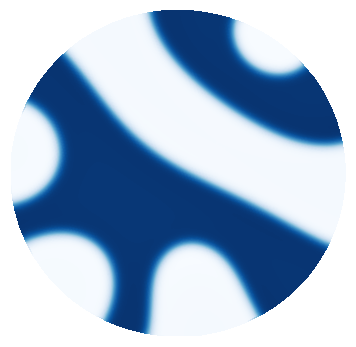

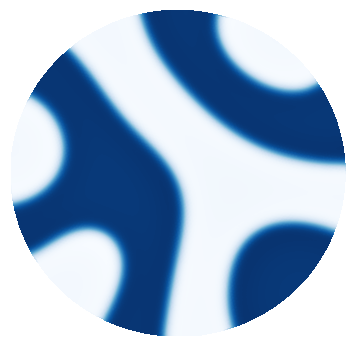

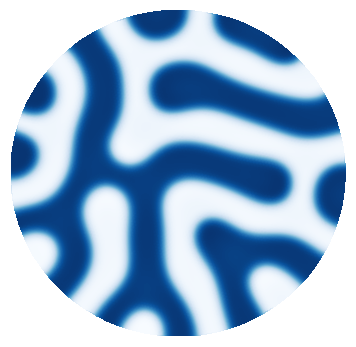

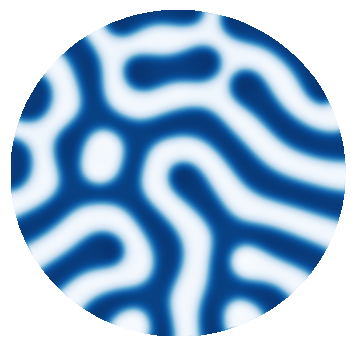

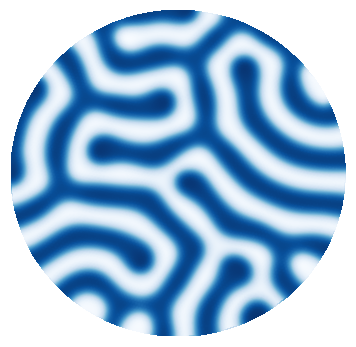

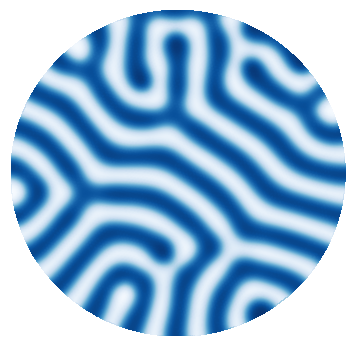

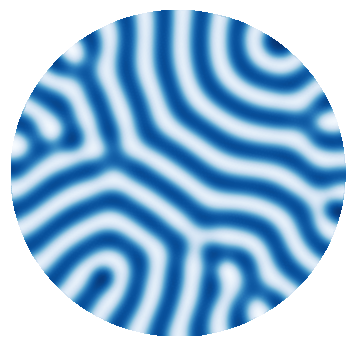

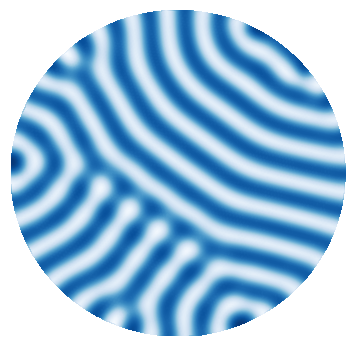

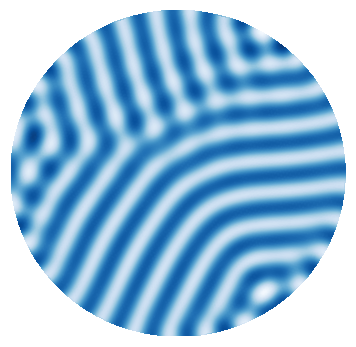

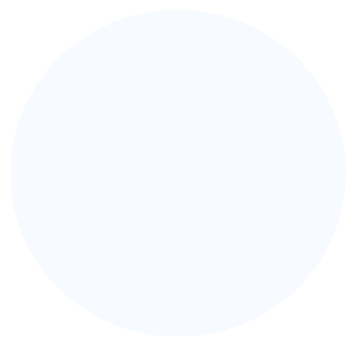

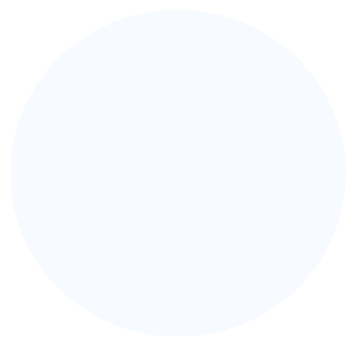

In [121]:
# Make the figures for concentration profile

K_list = [0.0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

figure_parameters = {'num_components': 2,
                     'component_indices': [0],
                     'color_map': ["Blues"],
                     'titles': ["Protein"],
                     'figure_size': [6, 6],
                     'keep_axes_labels': False
                    }

base_path = '/nfs/arupclab001/npradeep96/Stability_analysis/SimulationsForPaper/Comparing_LSA_predictions_to_simulations/Impact_of_k_on_wavelength_AB'
pattern = 'M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_{K_value}_c_initial_1.0_noise_variance_0.5'

for j in range(len(K_list)):
    
    K = K_list[j]
    directory_name = pattern.format(K_value=K)

    for subdir in os.listdir(base_path):
        # check if the subdirectory has a spatial variables files
        if subdir == directory_name and 'spatial_variables.hdf5' in os.listdir(os.path.join(base_path, subdir)):
            fig, axs = ia.plot_concentration(path=os.path.join(base_path, subdir), figure_parameters=figure_parameters)
            print(subdir)
            fig.savefig('Figures_for_paper/Figure_1/20230807_' 
                        + subdir + '_concentration.png', dpi=200, format='png', bbox_inches='tight', pad_inches=0.0)

M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_1.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.22479459, 3.72159931, 3.82150802]))
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_2.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.22479459, 2.97228401]))
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_3.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.22479459, 2.67255789]))
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_4.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.17484024, 2.37283178, 4.62077767]))
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_5.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.17484024, 2.22296872, 4.32105155]))
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_6.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.17484024, 2.17301436, 4.12123414]))


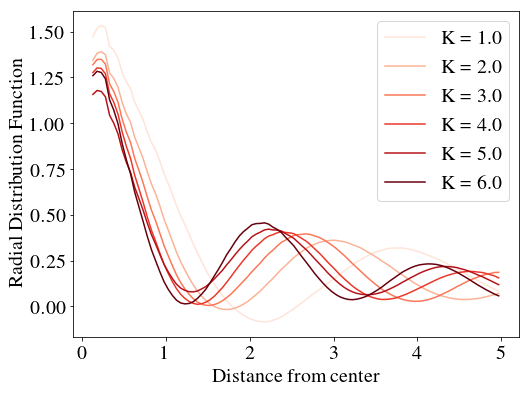

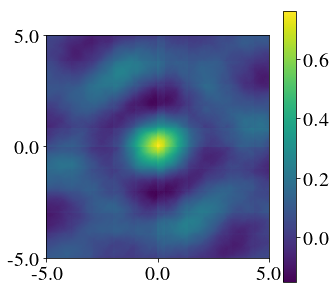

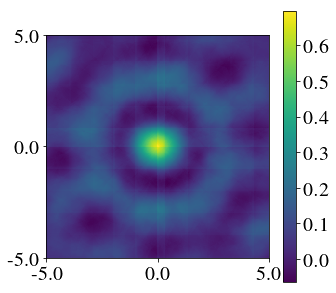

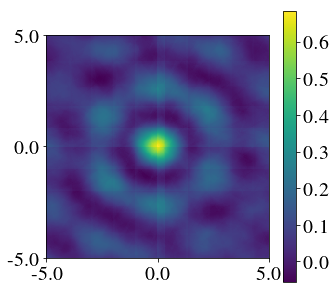

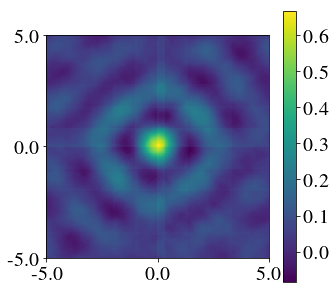

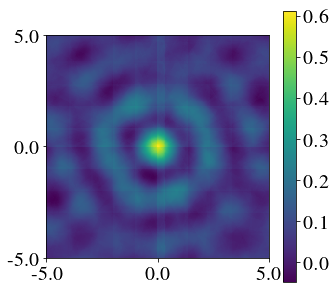

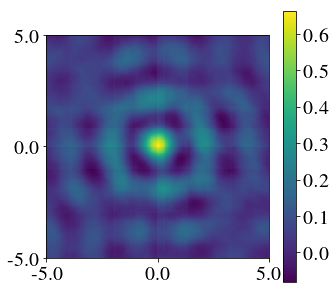

In [149]:
# Get the radial dsitribution function from the concentration profile

K_list = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

dominant_wave_numbers = np.zeros(len(K_list))

size_of_domain = [20.0, 20.0]

cmap = plt.get_cmap('Reds')
cvalues = np.linspace(0.1, 1.0, len(K_list))

rdf_fig, rdf_axs = plt.subplots(1, 1, figsize=(8,6))

for j in range(len(K_list)):
    
    K = K_list[j]
    directory_name = pattern.format(K_value=K)

    for subdir in os.listdir(base_path):
        
        if subdir == directory_name and 'spatial_variables.hdf5' in os.listdir(os.path.join(base_path, subdir)):

            print(subdir) 

            image = Image.open('Figures_for_paper/Figure_1/20230807_' + subdir + '_concentration.png').convert('L')  
            width, height = image.size
            length_per_pixel = 0.5*(size_of_domain[0]/width + size_of_domain[1]/height)

            # Calculate the autocorrelation matrix
            window_size = 463  # Should be an odd number for symmetric windowing
            autocorrelation_map = ia.calculate_autocorrelation(image, window_size=window_size, overlap_fraction=0.1)

            # Display the autocorrelation map
            fig, axs = plt.subplots(1, 1, figsize=(5,5))
            pos = axs.imshow(autocorrelation_map, cmap='viridis', origin='lower')
            fig.colorbar(pos, ax=axs)
            axs.set_xticks(np.linspace(1, window_size, 3))
            axs.set_yticks(np.linspace(0, window_size, 3))
            axs.set_xticklabels([int(-0.5*window_size*length_per_pixel*10)/10.0, 0.0, int(0.5*window_size*length_per_pixel*10)/10.0])
            axs.set_yticklabels([int(-0.5*window_size*length_per_pixel*10)/10.0, 0.0,  int(0.5*window_size*length_per_pixel*10)/10.0])
            
            fig.savefig('Figures_for_paper/Figure_1/20230808_' 
                   + subdir + '_autocorrelation.pdf', dpi=200, format='pdf', bbox_inches='tight', pad_inches=0.0)
            fig.savefig('Figures_for_paper/Figure_1/20230808_' 
                   + subdir + '_autocorrelation.png', dpi=200, format='png', bbox_inches='tight', pad_inches=0.0)

            # Calculate RDF
            r, rdf = ia.radial_distribution_function(autocorrelation_map)
            r = r*length_per_pixel

            # Smooth out the RDF
            smoothed_rdf = ia.smooth_radial_distribution_function(rdf, window_size=4)

            # Plot the RDF
            rdf_axs.plot(r[1:], smoothed_rdf[1:], label='K = ' + str(K), c=cmap(cvalues[j]))

            # Find the distances corresponding to the peaks of the RDF
            indices = ia.find_local_maxima_indices(smoothed_rdf)
            peak_distances = r[indices]
            print('Peak distances are ... ', peak_distances)
            if len(peak_distances) >= 2:
                dominant_wavelength = (peak_distances[1] - peak_distances[0])
                dominant_wave_numbers[j] = 2*np.pi/dominant_wavelength
                # print('dominant wavelength is:' + str(dominant_wavelength), '... dominant wave number is: ' + str(2*np.pi/dominant_wavelength))
            else:
                print('Not enough peaks in RDF to compute dominant wavelength')

rdf_axs.set_xlabel("Distance from center")
rdf_axs.set_ylabel("Radial Distribution Function")
rdf_axs.legend()
rdf_fig.savefig('Figures_for_paper/Figure_1/20230807_radial_distribution_functions_1.png', 
                dpi=600, format='png', bbox_inches='tight', pad_inches=0.0)
rdf_fig.savefig('Figures_for_paper/Figure_1/20230807_radial_distribution_functions_1.svg', 
                dpi=600, format='svg', bbox_inches='tight', pad_inches=0.0)

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


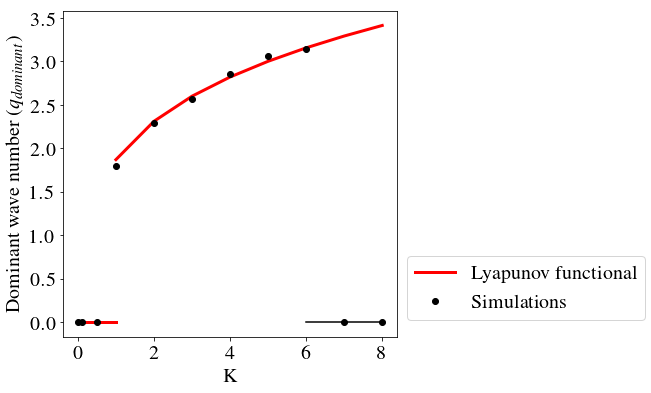

In [151]:
### Compare the dominant wavenumber predicted by analytical approximation vs. the full Lyapunov functional vs. simulations

K_list = [0.0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
params = {'M': 10.0, 'beta': -0.1, 'chi': 0.1, 'K': 1.0, 'kappa': 0.005, 'w': 0.1}

analytical_approx = np.sqrt(np.sqrt(np.array(K_list)*params['chi']/params['kappa']) - 1.0) 

# numerical computation by minimizing S(q)

numerically_computed_q = np.zeros(len(K_list))

for i in range(len(K_list)):
    K = K_list[i]
    params['K'] = K
    optimum = minimize(S_of_q, analytical_approx[i], args=(params))
    numerically_computed_q[i] = optimum.x

fig, axs = plt.subplots(1, 1, figsize=(6,6))
# axs.plot(np.sqrt(np.array(K_list)*params['chi']/params['kappa'])-1, analytical_approx, '-k', label='Analytical approx.')
axs.plot(K_list[3:], numerically_computed_q[3:], '-r', label='Lyapunov functional', linewidth=3)
axs.plot(K_list[:4], np.zeros(4), '-r', linewidth=3)
axs.plot(K_list, np.concatenate((np.zeros(3), dominant_wave_numbers, np.zeros(2))), 'ko', label='Simulations')
axs.plot(K_list[-3:], np.zeros(3), '-k')

axs.set_xlabel(r'K')
axs.set_ylabel(r'Dominant wave number ($q_{dominant}$)')
axs.legend(loc='center left', bbox_to_anchor=(1.0, 0.15), fontsize=20)
plt.savefig('Figures_for_paper/Figure_1/20230807_dominant_wavenumber_1.png', 
            dpi=600, format='png', bbox_inches='tight', pad_inches=0.0)
plt.savefig('Figures_for_paper/Figure_1/20230807_dominant_wavenumber_1.svg', 
            dpi=600, format='svg', bbox_inches='tight', pad_inches=0.0)

### $M\beta = -2.0 \, M\kappa = 0.05$

M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_0.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_0.5_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_1.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_1.5_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_2.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_3.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_4.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_5.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_6.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_8.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_10.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_12.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.0

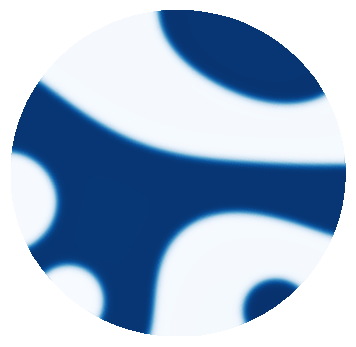

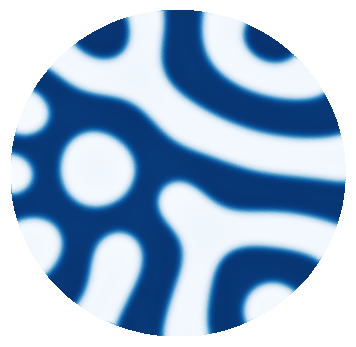

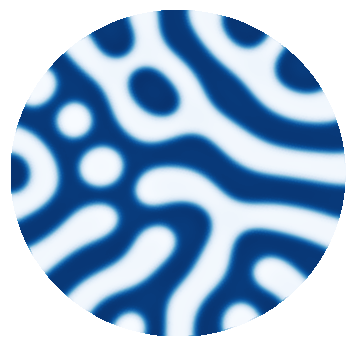

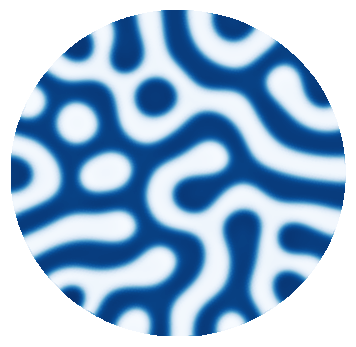

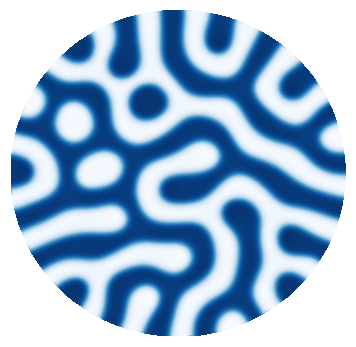

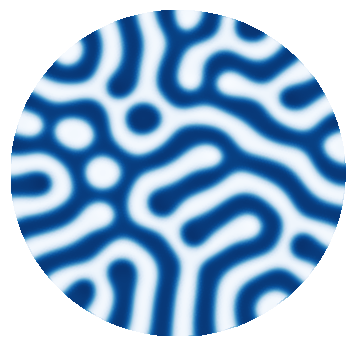

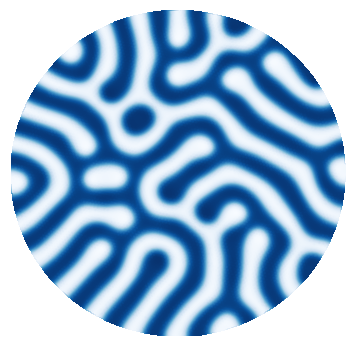

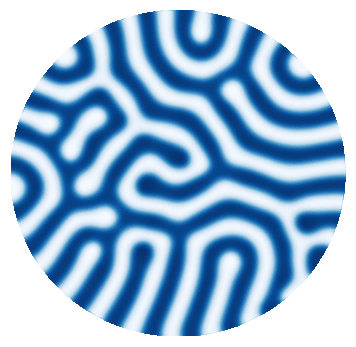

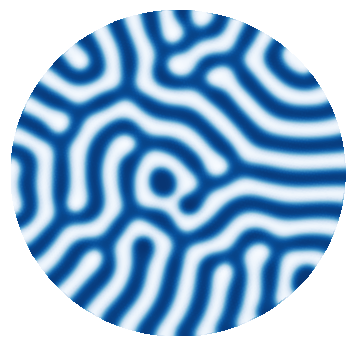

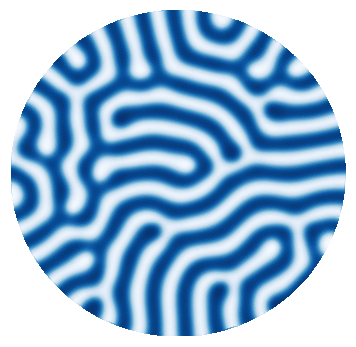

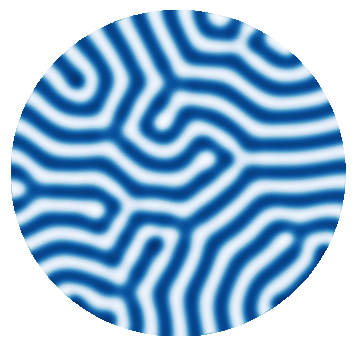

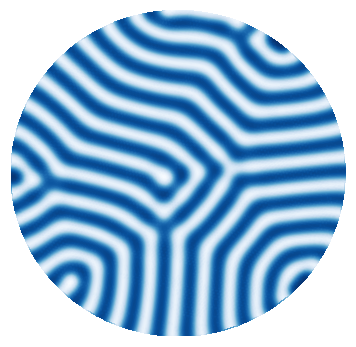

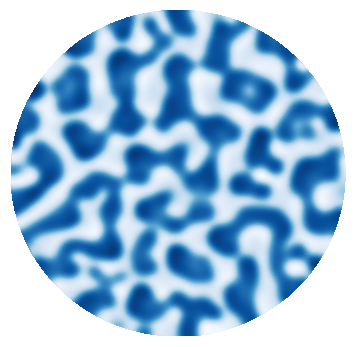

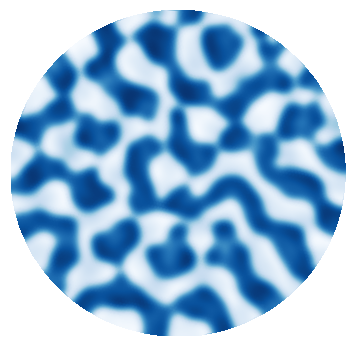

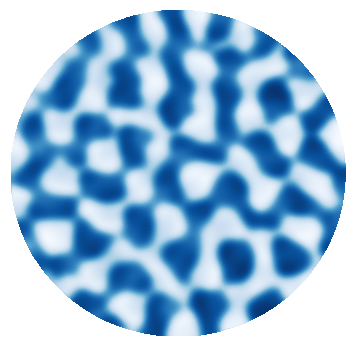

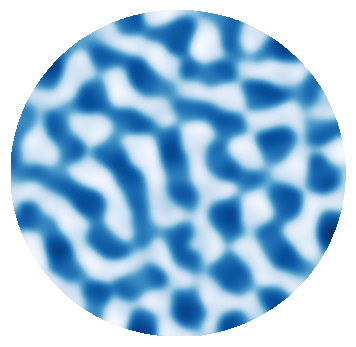

In [146]:
# Make the figures for concentration profile

K_list = [0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0, 14.0, 16.0, 20.0, 25.0]

figure_parameters = {'num_components': 2,
                     'component_indices': [0],
                     'color_map': ["Blues"],
                     'titles': ["Protein"],
                     'figure_size': [6, 6],
                     'keep_axes_labels': False
                    }

base_path = '/nfs/arupclab001/npradeep96/Stability_analysis/SimulationsForPaper/Comparing_LSA_predictions_to_simulations/Impact_of_k_on_wavelength_AB'
pattern = 'M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_{K_value}_c_initial_1.0_noise_variance_0.5'

for j in range(len(K_list)):
    
    K = K_list[j]
    directory_name = pattern.format(K_value=K)

    for subdir in os.listdir(base_path):
        # check if the subdirectory has a spatial variables files
        if subdir == directory_name and 'spatial_variables.hdf5' in os.listdir(os.path.join(base_path, subdir)):
            fig, axs = ia.plot_concentration(path=os.path.join(base_path, subdir), figure_parameters=figure_parameters)
            print(subdir)
            fig.savefig('Figures_for_paper/Figure_1/20230807_' 
                        + subdir + '_concentration.png', dpi=200, format='png', bbox_inches='tight', pad_inches=0.0)

M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_1.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.22479459, 3.72159931, 3.82150802]))
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_1.5_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.22479459, 3.32196449]))
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_2.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.22479459, 2.97228401]))
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_3.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.22479459, 2.67255789]))
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_4.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.17484024, 2.37283178, 4.62077767]))
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_5.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.17484024, 2.22296872, 4.32105155]))
M_1_10.0_beta_-0.2_gamma_0.1_kappa_0.005_K_6.0_c_initial_1.0_noise_variance_0.5
('Peak distances are ... ', array([0.1

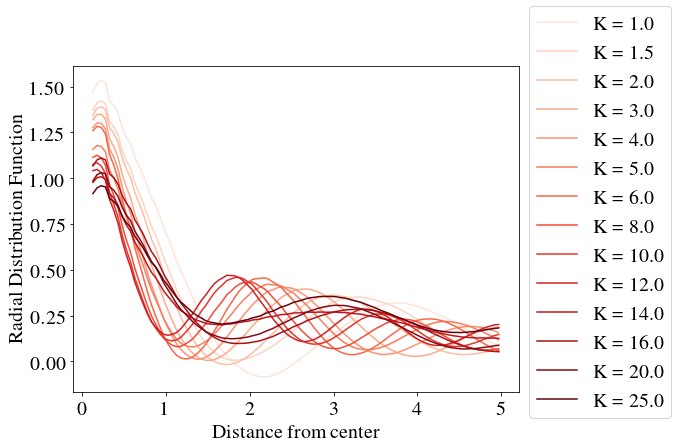

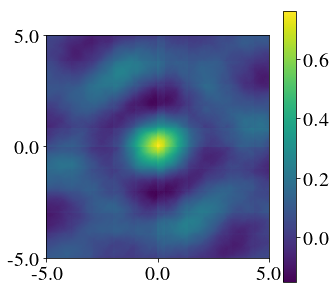

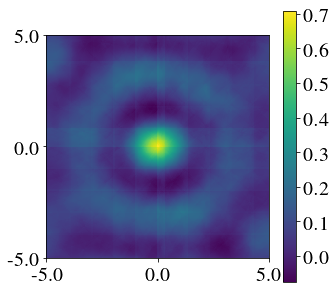

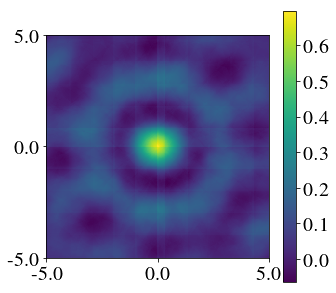

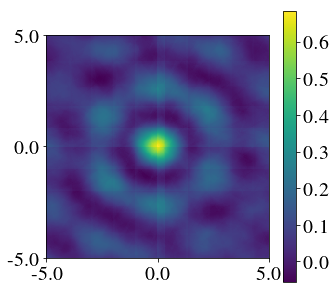

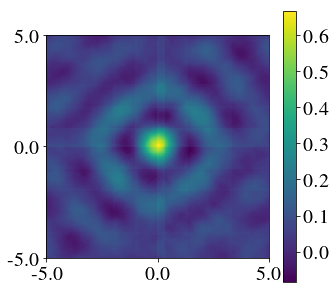

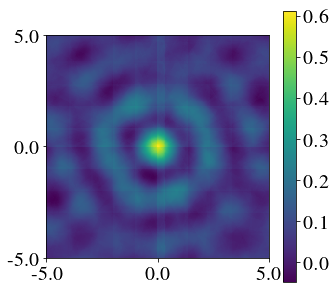

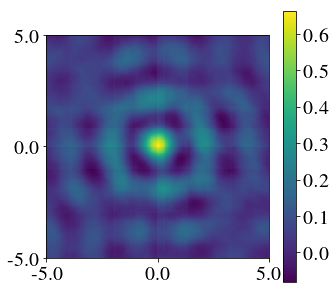

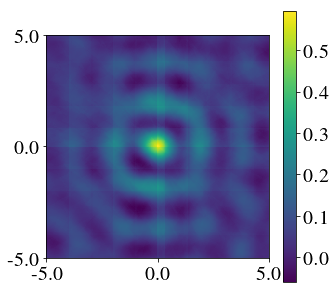

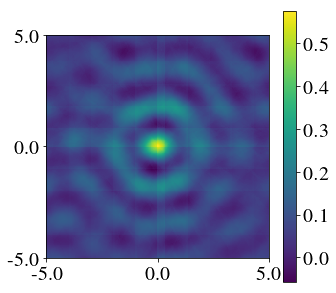

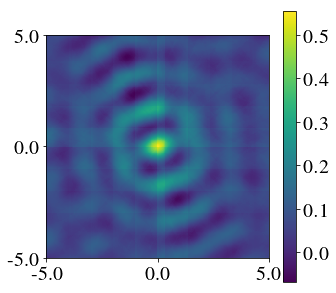

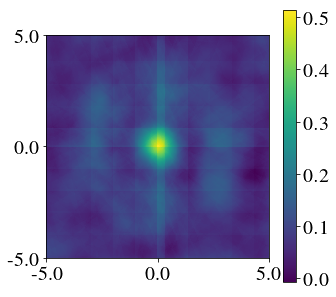

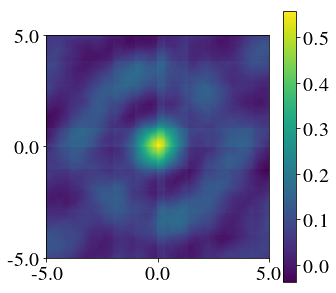

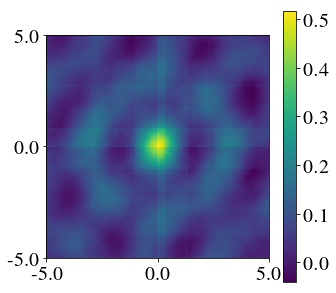

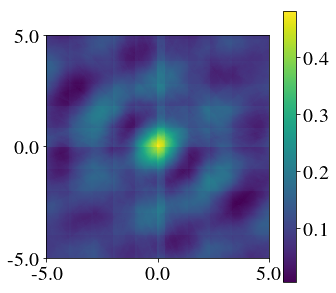

In [164]:
# Get the radial dsitribution function from the concentration profile

K_list = [1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 20.0, 25.0]

dominant_wave_numbers = np.zeros(len(K_list))

size_of_domain = [20.0, 20.0]

cmap = plt.get_cmap('Reds')
cvalues = np.linspace(0.1, 1.0, len(K_list))

rdf_fig, rdf_axs = plt.subplots(1, 1, figsize=(8,6))

for j in range(len(K_list)):
    
    K = K_list[j]
    directory_name = pattern.format(K_value=K)

    for subdir in os.listdir(base_path):
        
        if subdir == directory_name and 'spatial_variables.hdf5' in os.listdir(os.path.join(base_path, subdir)):

            print(subdir) 

            image = Image.open('Figures_for_paper/Figure_1/20230807_' + subdir + '_concentration.png').convert('L')  
            width, height = image.size
            length_per_pixel = 0.5*(size_of_domain[0]/width + size_of_domain[1]/height)

            # Calculate the autocorrelation matrix
            window_size = 463  # Should be an odd number for symmetric windowing
            autocorrelation_map = ia.calculate_autocorrelation(image, window_size=window_size, overlap_fraction=0.1)

            # Display the autocorrelation map
            fig, axs = plt.subplots(1, 1, figsize=(5,5))
            pos = axs.imshow(autocorrelation_map, cmap='viridis', origin='lower')
            fig.colorbar(pos, ax=axs)
            axs.set_xticks(np.linspace(1, window_size, 3))
            axs.set_yticks(np.linspace(0, window_size, 3))
            axs.set_xticklabels([int(-0.5*window_size*length_per_pixel*10)/10.0, 0.0, int(0.5*window_size*length_per_pixel*10)/10.0])
            axs.set_yticklabels([int(-0.5*window_size*length_per_pixel*10)/10.0, 0.0,  int(0.5*window_size*length_per_pixel*10)/10.0])
            
            fig.savefig('Figures_for_paper/Figure_1/20230808_' 
                   + subdir + '_autocorrelation.pdf', dpi=200, format='pdf', bbox_inches='tight', pad_inches=0.0)
            fig.savefig('Figures_for_paper/Figure_1/20230808_' 
                   + subdir + '_autocorrelation.png', dpi=200, format='png', bbox_inches='tight', pad_inches=0.0)

            # Calculate RDF
            r, rdf = ia.radial_distribution_function(autocorrelation_map)
            r = r*length_per_pixel

            # Smooth out the RDF
            smoothed_rdf = ia.smooth_radial_distribution_function(rdf, window_size=4)

            # Plot the RDF
            rdf_axs.plot(r[1:], smoothed_rdf[1:], label='K = ' + str(K), c=cmap(cvalues[j]))

            # Find the distances corresponding to the peaks of the RDF
            indices = ia.find_local_maxima_indices(smoothed_rdf)
            peak_distances = r[indices]
            print('Peak distances are ... ', peak_distances)
            if len(peak_distances) >= 2:
                dominant_wavelength = (peak_distances[1] - peak_distances[0])
                dominant_wave_numbers[j] = 2*np.pi/dominant_wavelength
                # print('dominant wavelength is:' + str(dominant_wavelength), '... dominant wave number is: ' + str(2*np.pi/dominant_wavelength))
            else:
                print('Not enough peaks in RDF to compute dominant wavelength')

rdf_axs.set_xlabel("Distance from center")
rdf_axs.set_ylabel("Radial Distribution Function")
rdf_axs.legend(loc='center left', bbox_to_anchor=(1.0, 0.55), fontsize=20)
rdf_fig.savefig('Figures_for_paper/Figure_1/20230807_radial_distribution_functions_2.png', 
                dpi=600, format='png', bbox_inches='tight', pad_inches=0.0)
rdf_fig.savefig('Figures_for_paper/Figure_1/20230807_radial_distribution_functions_2.svg', 
                dpi=600, format='svg', bbox_inches='tight', pad_inches=0.0)

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


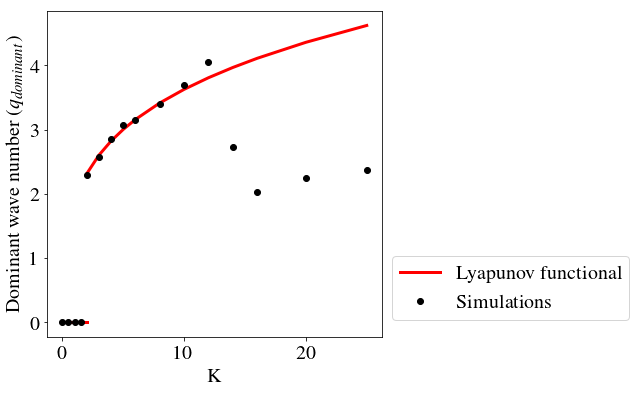

In [166]:
### Compare the dominant wavenumber predicted by analytical approximation vs. the full Lyapunov functional vs. simulations

K_list = [0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 20.0, 25.0]
params = {'M': 10.0, 'beta': -0.1, 'chi': 0.1, 'K': 1.0, 'kappa': 0.005, 'w': 0.1}

analytical_approx = np.sqrt(np.sqrt(np.array(K_list)*params['chi']/params['kappa']) - 1.0) 

# numerical computation by minimizing S(q)

numerically_computed_q = np.zeros(len(K_list))

for i in range(len(K_list)):
    K = K_list[i]
    params['K'] = K
    optimum = minimize(S_of_q, analytical_approx[i], args=(params))
    numerically_computed_q[i] = optimum.x

fig, axs = plt.subplots(1, 1, figsize=(6,6))
# axs.plot(np.sqrt(np.array(K_list)*params['chi']/params['kappa'])-1, analytical_approx, '-k', label='Analytical approx.')
axs.plot(K_list[4:], numerically_computed_q[4:], '-r', label='Lyapunov functional', linewidth=3)
axs.plot(K_list[:5], np.zeros(5), '-r', linewidth=3)
axs.plot(K_list[4:], dominant_wave_numbers[2:], 'ko', label='Simulations')
axs.plot(K_list[:4], np.zeros(4), 'ko')

axs.set_xlabel(r'K')
axs.set_ylabel(r'Dominant wave number ($q_{dominant}$)')
axs.legend(loc='center left', bbox_to_anchor=(1.0, 0.15), fontsize=20)
plt.savefig('Figures_for_paper/Figure_1/20230807_dominant_wavenumber_2.png', 
            dpi=600, format='png', bbox_inches='tight', pad_inches=0.0)
plt.savefig('Figures_for_paper/Figure_1/20230807_dominant_wavenumber_2.svg', 
            dpi=600, format='svg', bbox_inches='tight', pad_inches=0.0)

### Impact of surface tension on pattern dissolution

From a previous derivation, we showed that the increasing the surface tension can induce dissolution of the pattern. This happens as the wavelength of the pattern becomes smaller than the interface width set by surface tension. The criterion for this is given by $M\chi K > (M\kappa-M\beta)^2/4M\kappa$. 

For the below simulations done with $M\beta = 1.0$ and $M\chi K = 10.0$, we have dissolution when $M\kappa > 0.025$. This is exactly what we see in simulations too

M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.0005_K_10.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.001_K_10.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.0025_K_10.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_10.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.01_K_10.0_c_initial_1.0_noise_variance_0.5


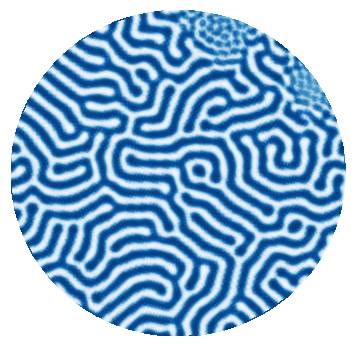

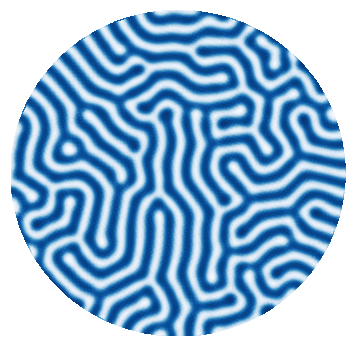

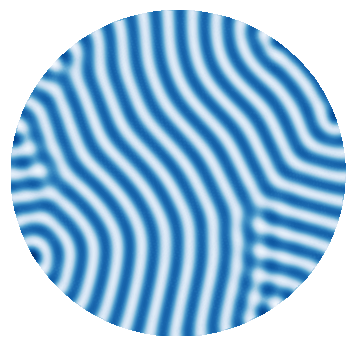

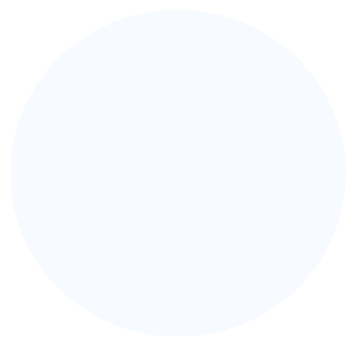

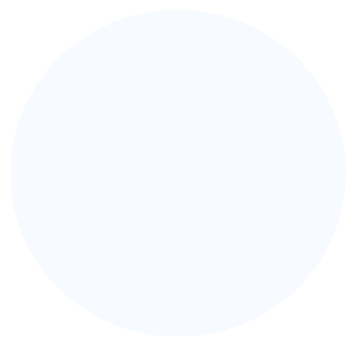

In [169]:
# Make the figures for concentration profile

kappa_list = [0.0005, 0.001, 0.0025, 0.005, 0.01]

figure_parameters = {'num_components': 2,
                     'component_indices': [0],
                     'color_map': ["Blues"],
                     'titles': ["Protein"],
                     'figure_size': [6, 6],
                     'keep_axes_labels': False
                    }

base_path = '/nfs/arupclab001/npradeep96/Stability_analysis/SimulationsForPaper/Comparing_LSA_predictions_to_simulations/Effect_of_surface_tension_new_AB/'
pattern = 'M_1_10.0_beta_-0.1_gamma_0.1_kappa_{kappa_value}_K_10.0_c_initial_1.0_noise_variance_0.5'

for j in range(len(kappa_list)):
    
    kappa = kappa_list[j]
    directory_name = pattern.format(kappa_value=kappa)

    for subdir in os.listdir(base_path):
        # check if the subdirectory has a spatial variables files
        if subdir == directory_name and 'spatial_variables.hdf5' in os.listdir(os.path.join(base_path, subdir)):
            fig, axs = ia.plot_concentration(path=os.path.join(base_path, subdir), figure_parameters=figure_parameters)
            print(subdir)
            fig.savefig('Figures_for_paper/Figure_1/20230807_' 
                        + subdir + '_concentration.png', dpi=200, format='png', bbox_inches='tight', pad_inches=0.0)

M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.0005_K_10.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.001_K_10.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.0025_K_10.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_10.0_c_initial_1.0_noise_variance_0.5


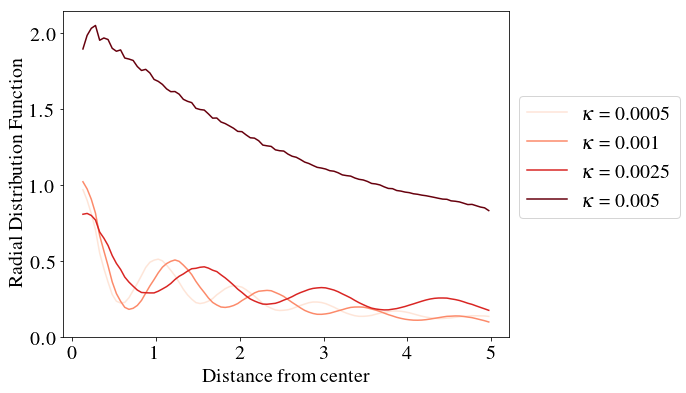

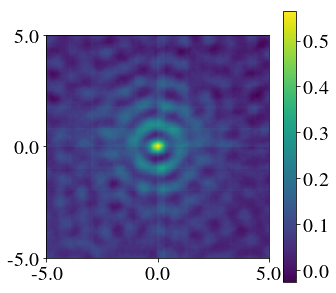

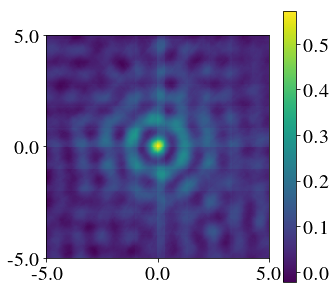

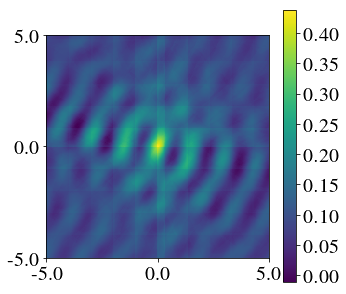

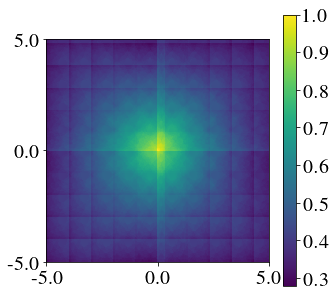

In [216]:
# Get the radial dsitribution function from the concentration profile

kappa_list = [0.0005, 0.001, 0.0025, 0.005]

size_of_domain = [20.0, 20.0]

cmap = plt.get_cmap('Reds')
cvalues = np.linspace(0.1, 1.0, len(kappa_list))

rdf_fig, rdf_axs = plt.subplots(1, 1, figsize=(8,6))

for j in range(len(kappa_list)):
    
    kappa = kappa_list[j]
    directory_name = pattern.format(kappa_value=kappa)

    for subdir in os.listdir(base_path):
        
        if subdir == directory_name and 'spatial_variables.hdf5' in os.listdir(os.path.join(base_path, subdir)):

            print(subdir) 

            image = Image.open('Figures_for_paper/Figure_1/20230807_' + subdir + '_concentration.png').convert('L')  
            width, height = image.size
            length_per_pixel = 0.5*(size_of_domain[0]/width + size_of_domain[1]/height)

            # Calculate the autocorrelation matrix
            window_size = 463  # Should be an odd number for symmetric windowing
            autocorrelation_map = ia.calculate_autocorrelation(image, window_size=window_size, overlap_fraction=0.1)

            # Display the autocorrelation map
            fig, axs = plt.subplots(1, 1, figsize=(5,5))
            pos = axs.imshow(autocorrelation_map, cmap='viridis', origin='lower')
            fig.colorbar(pos, ax=axs)
            axs.set_xticks(np.linspace(1, window_size, 3))
            axs.set_yticks(np.linspace(0, window_size, 3))
            axs.set_xticklabels([int(-0.5*window_size*length_per_pixel*10)/10.0, 0.0, int(0.5*window_size*length_per_pixel*10)/10.0])
            axs.set_yticklabels([int(-0.5*window_size*length_per_pixel*10)/10.0, 0.0,  int(0.5*window_size*length_per_pixel*10)/10.0])
            
            fig.savefig('Figures_for_paper/Figure_1/20230808_' 
                   + subdir + '_autocorrelation.pdf', dpi=200, format='pdf', bbox_inches='tight', pad_inches=0.0)
            fig.savefig('Figures_for_paper/Figure_1/20230808_' 
                   + subdir + '_autocorrelation.png', dpi=200, format='png', bbox_inches='tight', pad_inches=0.0)

            # Calculate RDF
            r, rdf = ia.radial_distribution_function(autocorrelation_map)
            r = r*length_per_pixel

            # Smooth out the RDF
            smoothed_rdf = ia.smooth_radial_distribution_function(rdf, window_size=4)

            # Plot the RDF
            rdf_axs.plot(r[1:], smoothed_rdf[1:], label=r'$\kappa$ = ' + str(kappa), c=cmap(cvalues[j]))

rdf_axs.set_xlabel("Distance from center")
rdf_axs.set_ylabel("Radial Distribution Function")
rdf_axs.legend(loc='center left', bbox_to_anchor=(1.0, 0.55), fontsize=20)
rdf_fig.savefig('Figures_for_paper/Figure_1/20230807_radial_distribution_functions_3.png', 
                dpi=600, format='png', bbox_inches='tight', pad_inches=0.0)
rdf_fig.savefig('Figures_for_paper/Figure_1/20230807_radial_distribution_functions_3.svg', 
                dpi=600, format='svg', bbox_inches='tight', pad_inches=0.0)

In [213]:
def get_intensity_histogram(image):
    """
    Get and plot the histogram of pixel intensities from an image.

    Parameters:
        image (np.ndarray): Input image.

    Returns:
        None
    """
    
    # Calculate the histogram
    histogram, bins = np.histogram(image, bins=40, range=(0, 256))
    bins = 0.5*(bins[:-1] + bins[1:])
    return histogram, bins

M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.0005_K_10.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.001_K_10.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.0025_K_10.0_c_initial_1.0_noise_variance_0.5
M_1_10.0_beta_-0.1_gamma_0.1_kappa_0.005_K_10.0_c_initial_1.0_noise_variance_0.5


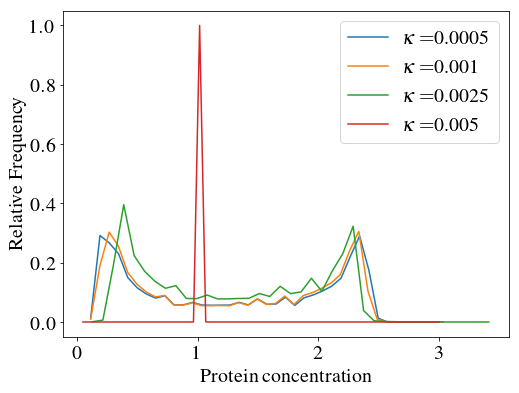

In [215]:
kappa_list = [0.0005, 0.001, 0.0025, 0.005]

fig, axs = plt.subplots(1,1,figsize=(8,6))

for j in range(len(kappa_list)):
    
    kappa = kappa_list[j]
    directory_name = pattern.format(kappa_value=kappa)

    for subdir in os.listdir(base_path):
        
        if subdir == directory_name and 'spatial_variables.hdf5' in os.listdir(os.path.join(base_path, subdir)):

            print(subdir) 

            image = Image.open('Figures_for_paper/Figure_1/20230807_' + subdir + '_concentration.png').convert('L')  
            hist, bins = get_intensity_histogram(image)
            
            # Plot the histogram
            hist = hist[::-1]
            total_pixels = np.sum(hist)
            average_intensity = np.sum(hist * bins)/total_pixels
            c_values = bins/average_intensity
            
            if kappa in [0.005, 0.01]:
                c_values = np.linspace(0, 3, 60)
                hist = np.zeros(len(c_values))
                hist[20] = 1.0
            
            axs.plot(c_values[1:], np.array(hist[1:], dtype=float)/np.max(hist), label='$\kappa=$'+str(kappa))
            # plt.title("Histogram of Pixel Intensities")

axs.set_xlabel("Protein concentration")
axs.set_ylabel("Relative Frequency")
# axs.set_xlim([0,3])
axs.legend()
plt.show()

### Impact of transcription rate on oscillation frequency